<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
от количества батчей напрямую зависит размер оперативной памяти.

Посмотрим на какую-нибудь картинку:

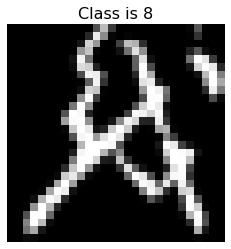

In [4]:
plt.imshow(trainset[59999][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





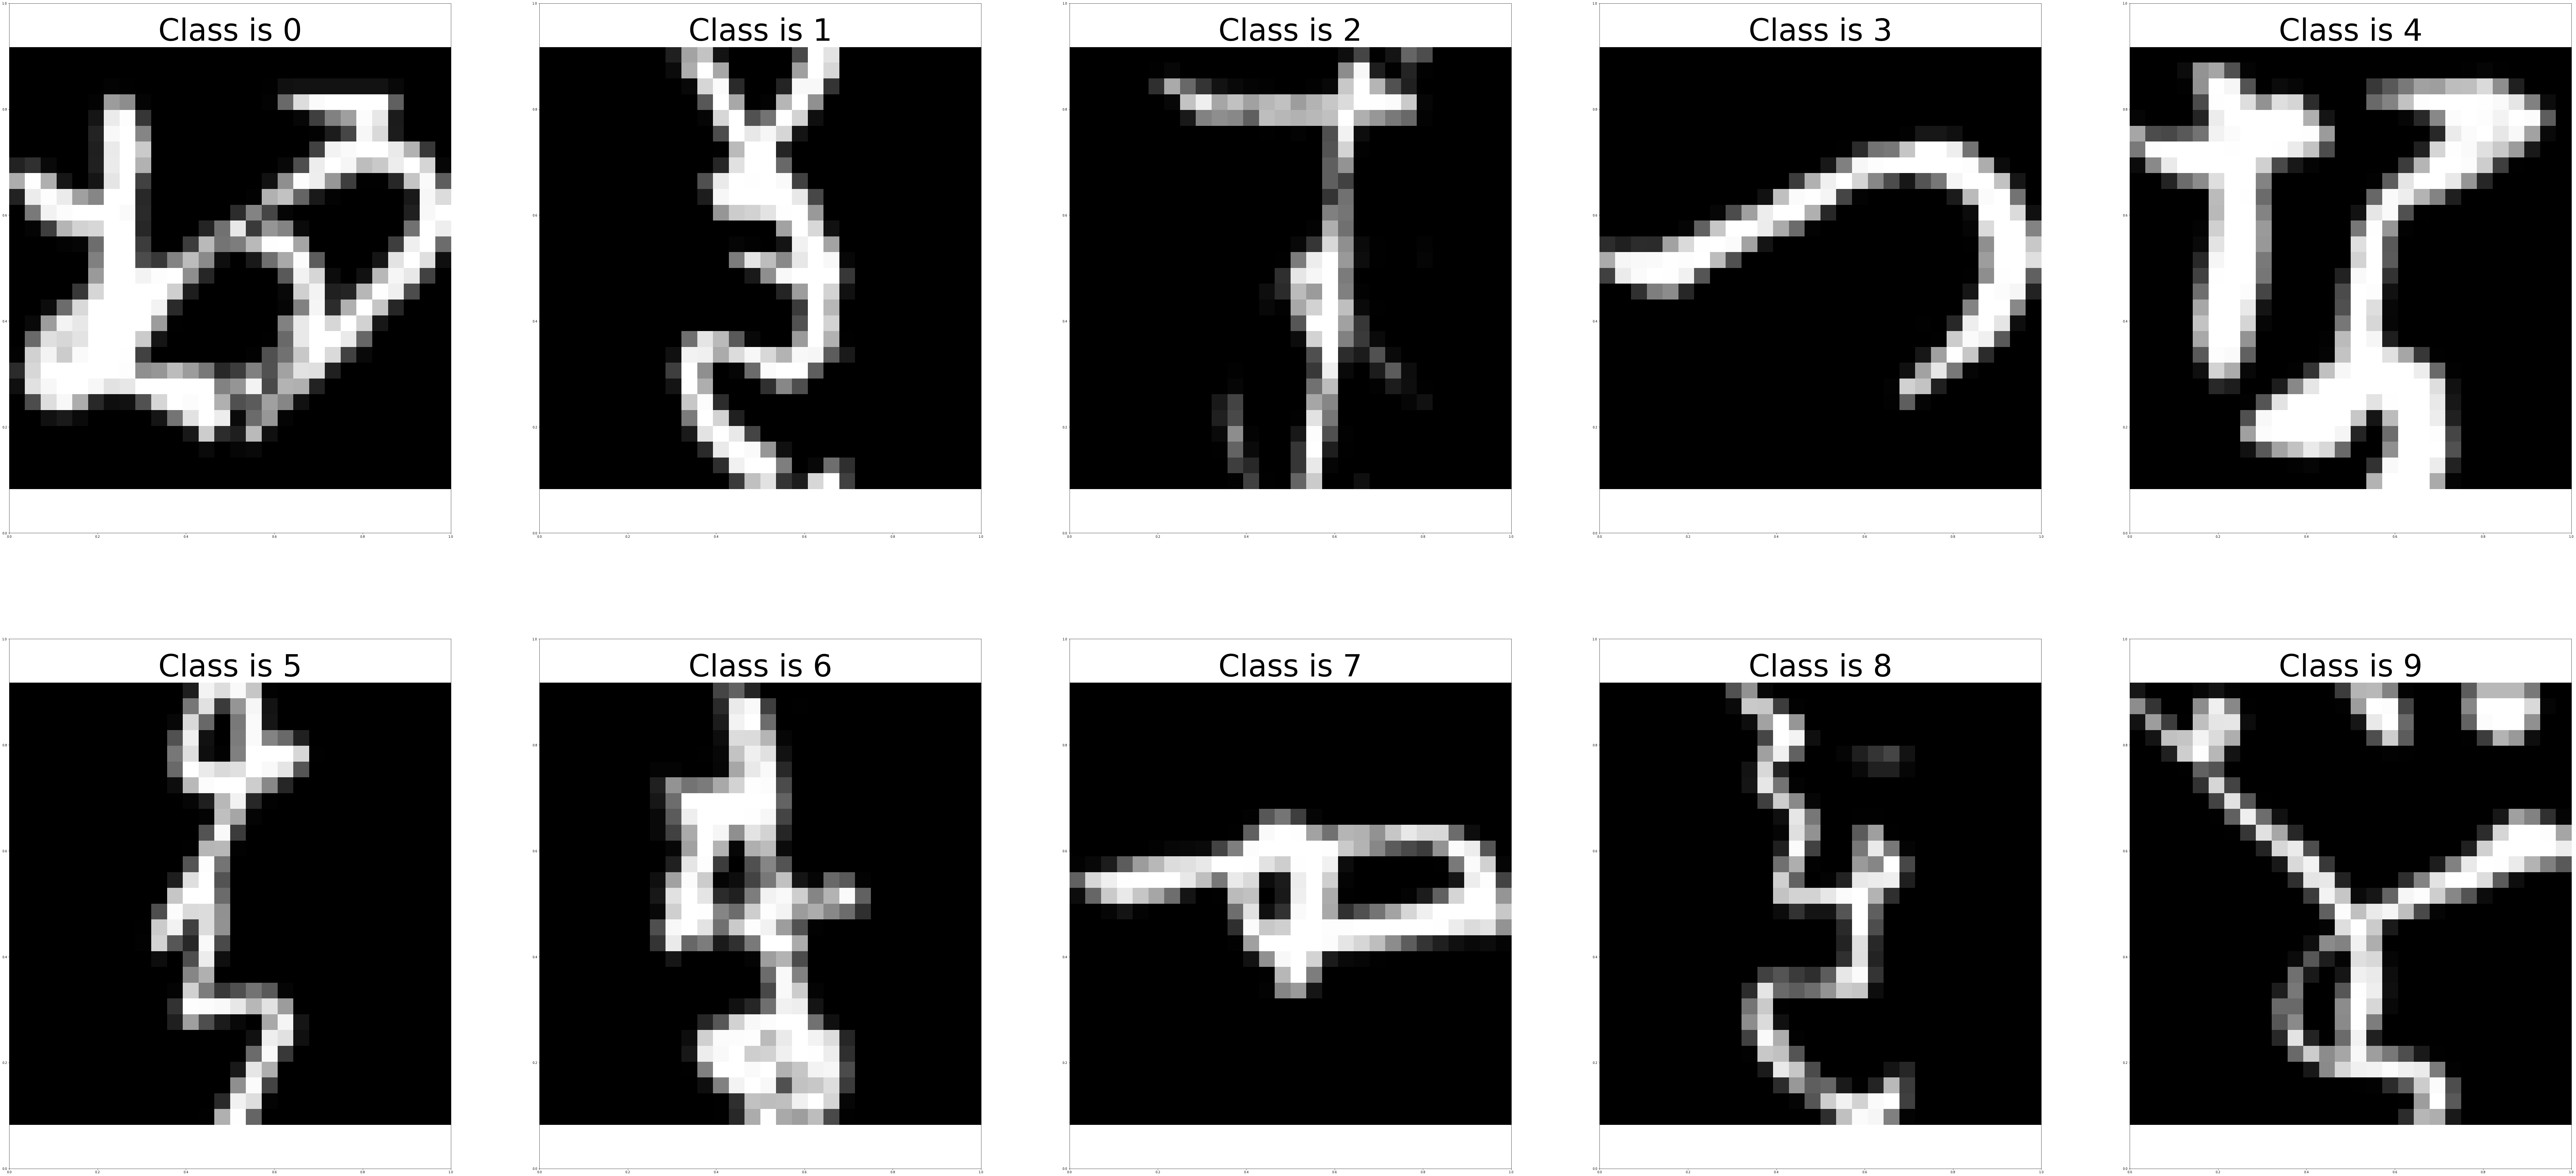

In [6]:
class_ex = []
class_num = 0
for i in range(len(trainset)):
    if trainset[i][1] == class_num:
        class_ex.append(trainset[i])
        class_num += 1

rows = 2
columns = 5
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(150, 70))
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    image = class_ex[i-1][0].view(28, 28).numpy()
    plt.imshow(image, cmap="gray")
    plt.axis("off")  
    plt.title(f"Class is {class_ex[i-1][1]}", fontsize=100)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [7]:
import torch.nn.functional as F
import torch.nn as nn

In [8]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        logits = F.softmax(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**
235146 обучаемых параметров

In [9]:
model = FCNet()
sum([p.numel() for p in model.parameters() if p.requires_grad])

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [10]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [11]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
# lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [12]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

<ipython-input-8-c0795c2e5daf>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(x)


Epoch=1 loss=1.8718
Epoch=2 loss=1.6891
Epoch=3 loss=1.6495
Epoch=4 loss=1.6361
Epoch=5 loss=1.6265
Epoch=6 loss=1.6182
Epoch=7 loss=1.6115
Epoch=8 loss=1.6060
Epoch=9 loss=1.5998
Epoch=10 loss=1.5909


In [13]:
accuracy_before_norm = get_accuracy(fc_net, testloader)

<ipython-input-8-c0795c2e5daf>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(x)


In [14]:
accuracy_before_norm

0.7188

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [15]:
sum_pixels = 0.0
sum_sq_pixels = 0.0
total_pixels = 0

for batch in trainloader:
    data, _ = batch
    total_pixels += data.numel()
    sum_pixels += torch.sum(data)
    sum_sq_pixels += torch.sum(data ** 2)

mean = sum_pixels / total_pixels
std = torch.sqrt(sum_sq_pixels / total_pixels - mean ** 2)
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [16]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [17]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

<ipython-input-8-c0795c2e5daf>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(x)


Epoch=1 loss=1.7640
Epoch=2 loss=1.6360
Epoch=3 loss=1.6146
Epoch=4 loss=1.5896
Epoch=5 loss=1.5723
Epoch=6 loss=1.5607
Epoch=7 loss=1.5528
Epoch=8 loss=1.5465
Epoch=9 loss=1.5412
Epoch=10 loss=1.5373


In [18]:
accuracy_after_norm = get_accuracy(fc_net, testloader)

<ipython-input-8-c0795c2e5daf>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(x)


Как изменилась `accuracy` после нормализации?

In [20]:
print(f'Accuracy после нормализации изменился на {round(accuracy_after_norm - accuracy_before_norm, 6)}')

Accuracy после нормализации изменился на 0.0808


### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [22]:
## YOUR CODE HERE
class FCNet(nn.Module):
    def __init__(self, act_func):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.act_func = act_func


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        logits = self.act_func(x)

        return logits

In [28]:
def train_net(act_func, testloader):
    fc_net = FCNet(act_func)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

    n_epochs = 10
    loss_history = []

    ## YOUR CODE HERE
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(trainloader))
    
    return get_accuracy(fc_net, testloader)

In [32]:
accuracy_sigmoid = train_net(F.sigmoid, testloader)
accuracy_gelu = train_net(F.gelu, testloader)
accuracy_tanh = train_net(F.tanh, testloader)

In [35]:
scores = {
    'sigmoid':accuracy_sigmoid, 
    'GELU': accuracy_gelu, 
    'Tanh': accuracy_tanh
}

{'sigmoid': 0.878, 'GELU': 0.8492, 'Tanh': 0.8917}

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [46]:
max_acc_score = max(scores.values())
cur_func = [func for func, value in scores.items() if value == max_acc_score][0]
print(f'Максимальное значение accuracy, равное {max_acc_score}, получено при использование функции активации - {cur_func}.')

Максимальное значение accuracy, равное 0.8917, получено при использование функции активации - Tanh.


### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [50]:
from torch.optim import Adam, RMSprop, Adagrad

In [51]:
def train_net(act_func, optimizer, testloader):
    fc_net = FCNet(act_func)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer(fc_net.parameters(), lr=3e-4)

    n_epochs = 10
    loss_history = []

    ## YOUR CODE HERE
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(trainloader))
    
    return get_accuracy(fc_net, testloader)

In [55]:
accuracy_tanh_adam = train_net(F.tanh, Adam, testloader)
accuracy_tanh_rmsprop = train_net(F.tanh, RMSprop, testloader)
accuracy_tanh_adagrad = train_net(F.tanh, Adagrad, testloader)

In [56]:
scores_opt = {
    'Adam':accuracy_tanh_adam, 
    'RMSProp': accuracy_tanh_rmsprop, 
    'Adagrad': accuracy_tanh_adagrad
}

max_acc_score = max(scores_opt.values())
cur_func = [func for func, value in scores_opt.items() if value == max_acc_score][0]
print(f'Максимальное значение accuracy, равное {max_acc_score}, получено при использование оптимизатора - {cur_func}.')

Максимальное значение accuracy, равное 0.8949, получено при использование оптимизатора - RMSProp.


### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [107]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        
        return torch.max(x, torch.tensor(0.0))

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [103]:
class FCNetCustomReLU(nn.Module):
    def __init__(self, act_func, custom_relu):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.custom_relu = custom_relu
        self.act_func = act_func


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.custom_relu(x)
        x = self.fc2(x)
        x = self.custom_relu(x)
        x = self.fc3(x)
        logits = self.act_func(x)

        return logits

In [104]:
def train_net(act_func, custom_relu, optimizer, testloader):
    fc_net = FCNetCustomReLU(act_func, custom_relu)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer(fc_net.parameters(), lr=3e-4)

    n_epochs = 10
    loss_history = []

    ## YOUR CODE HERE
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(trainloader))
    
    return get_accuracy(fc_net, testloader)

In [108]:
custom_relu_score = train_net(F.tanh, CustomReLU(), RMSprop, testloader)

In [109]:
custom_relu_score

0.8917

Получилось почти такое же значение скора, как и со встроенным ReLU

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Картинки сгенерированы с помощью Chad AI:
1. ![Нарисуй выпускной института биоинформатики на базе отдыха в июне.](data/выпускной_иб.png)
2. ![Нарисуй как будет выглядеть минск через 100 лет.](data/минск_2124.png)
3. ![Нарисуй человека, который забрался на самое высокое здание в мире](data/человек_на_самом_высоком_здании.png)